# Analysis of Stereo-seq mouse olfactory bulb dataset

In this tutorial, we demonstrate SpaRCL on the analysis of Stereo-seq mouse olfactory bulb dataset including

* Spatial reconstruction
* Mini-batch relational contrastive learning
* Spatial domain identification
* Finding differentially expressed genes
* Spatial domain annotation

The dataset is available at [JinmiaoChenLab GitHub](https://github.com/JinmiaoChenLab/SEDR_analyses) (data >> Stero-seq.tar.gz).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import SpaRCL as rcl

## Data loading and preprocessing

We load the dataset and find top 8000 highly variable genes.

In [2]:
adata = sc.read_h5ad('./data/Stereo_seq.h5ad')
adata

AnnData object with n_obs × n_vars = 19527 × 27106
    obsm: 'spatial'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=8000, flavor='seurat_v3')

## Spatial reconstruction

We perform spatial reconstruction to aggregate expression from spatial neighbors.

In [4]:
rcl.spatial_reconstruction(adata, n_neighbors=30)

## Mini-batch relational contrastive learning

We select 4000 reference centers and then perform mini-batch relational contrastive learning on the reconstructed data.

In [5]:
sc.pp.pca(adata)
rcl.reference_centers(adata, n_centers=4000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Since this step takes some time, we load previously computed AnnData.

In [6]:
# rcl.run_RCL_minibatch(adata)

adata = sc.read_h5ad('./data/Stereo_seq_results.h5ad')
adata

AnnData object with n_obs × n_vars = 19527 × 27106
    obs: 'reference_centers'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'relation', 'pca', 'reference_centers', 'spatial_reconstruction'
    obsm: 'X_pca', 'relation', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log1p'

## Spatial domain identification

We create a temporary AnnData using the sample-by-reference relation matrix and then interoperate with SCANPY to identify spatial domains.

In [7]:
adata_V = sc.AnnData(adata.obsm['relation'])
adata_V.obs_names = adata.obs_names
adata_V.obsm['spatial'] = adata.obsm['spatial']
adata_V

AnnData object with n_obs × n_vars = 19527 × 3983
    obsm: 'spatial'

In [8]:
sc.pp.pca(adata_V)
sc.pp.neighbors(adata_V)

In [9]:
sc.tl.louvain(adata_V, resolution=0.4)

In [10]:
adata.obs['louvain'] = adata_V.obs['louvain']

We exclude domain 5 from downstream analysis, since its average count is lower than 100.

<AxesSubplot:xlabel='louvain'>

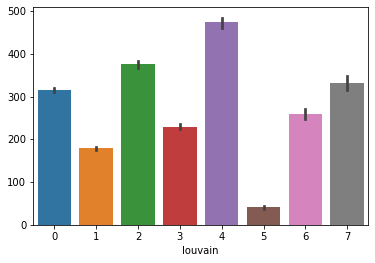

In [11]:
sns.barplot(y=np.sum(adata.layers['counts'].toarray(), axis=1), x=adata.obs['louvain'])

In [12]:
adata_subset = adata[~adata.obs['louvain'].isin(['5']),:]

Trying to set attribute `.uns` of view, copying.


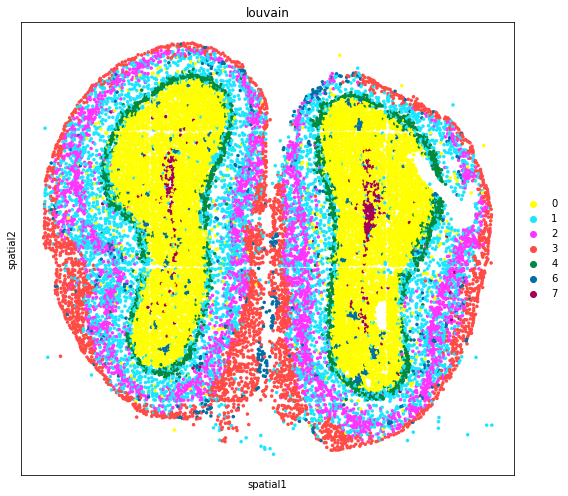

In [13]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.embedding(
    adata_subset,
    basis='spatial',
    color='louvain',
    size=50,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Finding differentially expressed genes

We find the differentially expressed (DE) genes across identified domains and show the domains and their DE gene expression patterns in spatial coordinates.

In [14]:
sc.tl.rank_genes_groups(adata_subset, groupby='louvain', use_raw=False, layer='counts', method='t-test_overestim_var')

In [15]:
de_genes = pd.DataFrame(adata_subset.uns['rank_genes_groups']['names']).iloc[:10,:]
de_genes

,0,1,2,3,4,6,7
0,Pcp4,Vip,Cmss1,Apod,Nme7,Hbb-bs,Plp1
1,Nrxn3,Lcat,Gm42418,Ptn,Snap25,Hba-a1,Mbp
2,Ppp3ca,Fam98c,Cck,Ptgds,Scg2,Hbb-bt,Fth1
3,Kcnb2,Gm10610,Cdk8,Atp1a2,Gabra1,Hba-a2,Trf
4,Camk2n1,Ly6c1,Nrsn1,Apoe,Gm42418,Ptgds,Cldn11
5,Tshz1,Gm48843,Calb2,Fabp7,Cpe,Apex2,Mal
6,Meis2,Vmn1r67,Nxph1,S100a5,Uchl1,Mgp,Sox11
7,Pbx3,Esp34,Olfm1,Kctd12,Syt1,Igf2,Mag
8,Camk2b,Tnfsf15,Sparcl1,Gng13,Cltc,Dcn,Zfp704
9,Calm2,AC124606.2,Ptprd,Npy,Slc17a7,Acta2,Mobp


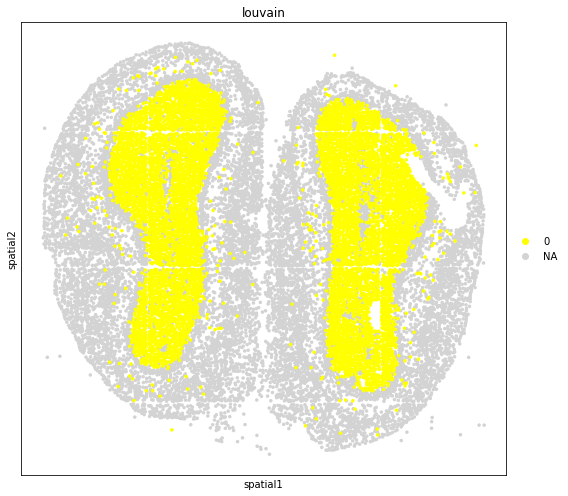

In [16]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.embedding(
    adata_subset,
    basis='spatial',
    color='louvain',
    groups='0',
    layer='log1p',
    size=50,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

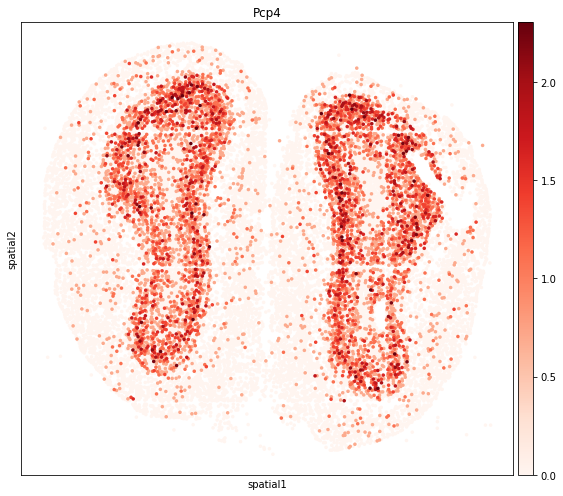

In [17]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.embedding(
    adata_subset,
    basis='spatial',
    color=de_genes.iloc[0,0],
    layer='log1p',
    size=50,
    color_map='Reds',
    vmax='p99.9',
    show=False,
    ax=axs,
)

plt.tight_layout()

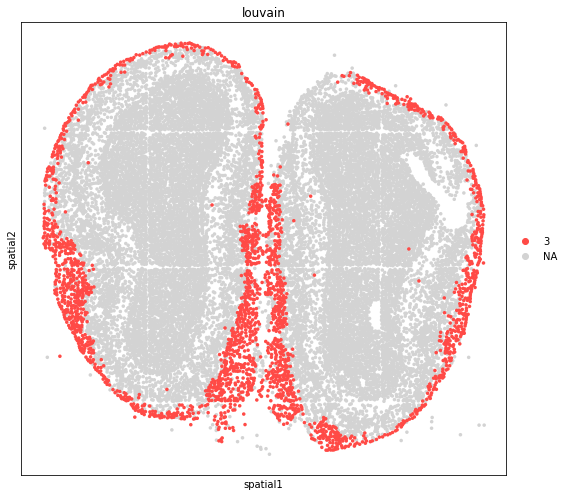

In [18]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.embedding(
    adata_subset,
    basis='spatial',
    color='louvain',
    groups='3',
    layer='log1p',
    size=50,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

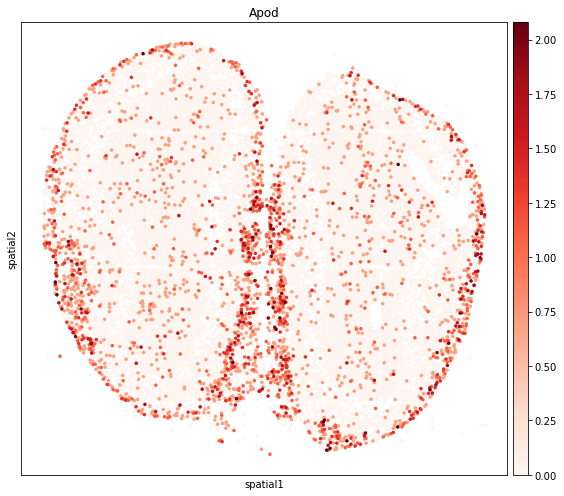

In [19]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.embedding(
    adata_subset,
    basis='spatial',
    color=de_genes.iloc[0,3],
    layer='log1p',
    size=50,
    color_map='Reds',
    vmax='p99.9',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Spatial domain annotation

We annotate the spatial domains based on the anatomical annotation from [Fu, H. et al.](https://www.biorxiv.org/content/10.1101/2021.06.15.448542v2) and marker genes.

In [20]:
map_dict = {
    '0': 'GCL',
    '1': 'EPL',
    '2': 'GL',
    '3': 'ONL',
    '4': 'MCL',
    '6': 'BLD',
    '7': 'RMS',
}

In [21]:
adata_subset.obs['annotation'] = adata_subset.obs['louvain'].map(map_dict).astype('category')

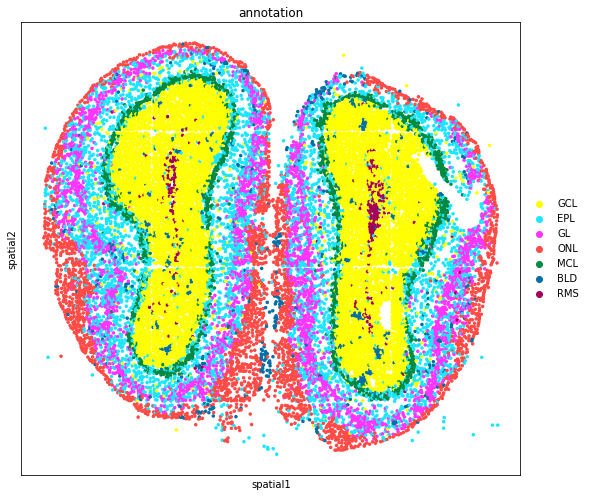

In [22]:
fig, axs = plt.subplots(figsize=(8.3, 7))

sc.pl.embedding(
    adata_subset,
    basis='spatial',
    color='annotation',
    size=50,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()